In [223]:
import os
import time
import librosa
import librosa.display as dsp
from IPython.display import Audio
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import sklearn
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier, XGBRFClassifier
from xgboost import plot_tree, plot_importance
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from joblib import Parallel, delayed
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tqdm import tqdm
from sklearn.model_selection import GridSearchCV
import random

# Parse the dataset

In [375]:
base_dir1 = r"/Users/zhouzuojun/Desktop/675data/voxceleb1/wav1"
base_dir2 = r"/Users/zhouzuojun/Desktop/675data/voxceleb1/wav2"
#base_dir3 = r"/Users/zhouzuojun/Desktop/675data/voxceleb1/vox1_test_wav"

def get_audio_file_paths(base_dir):
    audio_files = []
    for speaker_id in os.listdir(base_dir):
        speaker_dir = os.path.join(base_dir, speaker_id)
        if os.path.isdir(speaker_dir):
            for video_id in os.listdir(speaker_dir):
                video_dir = os.path.join(speaker_dir, video_id)
                if os.path.isdir(video_dir):
                    for file in os.listdir(video_dir):
                        if file.endswith('.wav'):
                            audio_files.append({
                                "speaker_id": speaker_id,
                                "video_id": video_id,
                                "file_path": os.path.join(video_dir, file)
                            })
    return audio_files

audio_files = []
audio_files = audio_files + get_audio_file_paths(base_dir1)
audio_files = audio_files + get_audio_file_paths(base_dir2)
# audio_files = audio_files + get_audio_file_paths(base_dir2)
audio_df = pd.DataFrame(audio_files)
print(audio_df.head())


  speaker_id     video_id                                          file_path
0    id10384  vxBFGKGXSFA  /Users/zhouzuojun/Desktop/675data/voxceleb1/wa...
1    id10384  vxBFGKGXSFA  /Users/zhouzuojun/Desktop/675data/voxceleb1/wa...
2    id10384  vxBFGKGXSFA  /Users/zhouzuojun/Desktop/675data/voxceleb1/wa...
3    id10384  vxBFGKGXSFA  /Users/zhouzuojun/Desktop/675data/voxceleb1/wa...
4    id10384  vxBFGKGXSFA  /Users/zhouzuojun/Desktop/675data/voxceleb1/wa...


## Audio Features

In [256]:
def extract_features_with_strict_filter(file_path, sr=16000, fmin=50, fmax=500, hnr_threshold=0.2, energy_threshold=1e-4):
    try:
        y, sr = librosa.load(file_path, sr=sr)
        trimmed_y, _ = librosa.effects.trim(y, top_db=20)
        energy = np.sum(trimmed_y**2) / len(trimmed_y)
        if energy < energy_threshold: # low energy implies noise
            return None 
        f0, _, _ = librosa.pyin(trimmed_y, fmin=fmin, fmax=fmax)
        f0_mean = np.nanmean(f0) if f0 is not None and not np.isnan(f0).all() else 0
        f0_std = np.nanstd(f0) if f0 is not None and not np.isnan(f0).all() else 0
        harmonic, _ = librosa.effects.hpss(trimmed_y)
        hnr = np.sum(harmonic**2) / len(harmonic) if len(harmonic) > 0 else 0
        if f0_mean == 0 and f0_std == 0 and hnr < hnr_threshold:
            return None # Failure to detect vocal fold vibration and a low signal-to-noise ratio indicates that noise dominates.
        
        mfccs = librosa.feature.mfcc(y=trimmed_y, sr=sr, n_mfcc=13)
        delta_mfcc = librosa.feature.delta(mfccs)
        spectral_centroid = librosa.feature.spectral_centroid(y=trimmed_y, sr=sr)
        spectral_contrast = librosa.feature.spectral_contrast(y=trimmed_y, sr=sr)
        chroma = librosa.feature.chroma_stft(y=trimmed_y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(trimmed_y)
        
        features = np.hstack([
            f0_mean, f0_std,      
            hnr,                  
            mfccs.mean(axis=1),   
            delta_mfcc.mean(axis=1), 
            spectral_centroid.mean(axis=1), 
            spectral_contrast.mean(axis=1), 
            spectral_bandwidth.mean(axis=1), 
            chroma.mean(axis=1),  
            zcr.mean(axis=1),           
            energy               
        ])
        
        return features
    
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# test with the first sample
start = time.time()
sample_features = extract_features(audio_df['file_path'].iloc[0])
print("Sample Features:", sample_features)
print(f"Time: {time.time()-start}s")

Sample Features: [-1.47079117e+02  8.83980179e+01 -2.34582019e+00  5.61305046e+00
 -5.71199179e+00  1.20186386e+01 -6.87786198e+00  1.44321489e+00
 -6.95998192e+00 -2.34488592e-01 -8.19929409e+00 -4.60119295e+00
  2.53215122e+00  1.32586444e-01  7.14774530e-03  1.85703360e+03
  1.78248124e+03  1.91588840e+01  1.73434712e+01  1.90613251e+01
  1.81687955e+01  1.78130191e+01  1.77021511e+01  1.70088846e+01
  2.70792007e-01  2.38337979e-01  2.27691174e-01  2.51002580e-01
  2.64323920e-01  3.54344249e-01  3.52769047e-01  3.10297966e-01
  3.89537901e-01  4.44405556e-01  4.49627876e-01  4.15617526e-01
  2.85867932e+02  4.19686469e+01  2.73930259e-03 -2.88989395e-01
 -2.40450680e-01  3.27738315e-01  2.23182756e-02  3.71476170e-03
 -6.68901578e-02  5.91623746e-02  3.69932037e-03  1.09434471e-01
 -9.03484449e-02  5.78501774e-03 -1.82209965e-02 -8.12159926e-02]
Time: 0.5131430625915527s


## Important feature visualization

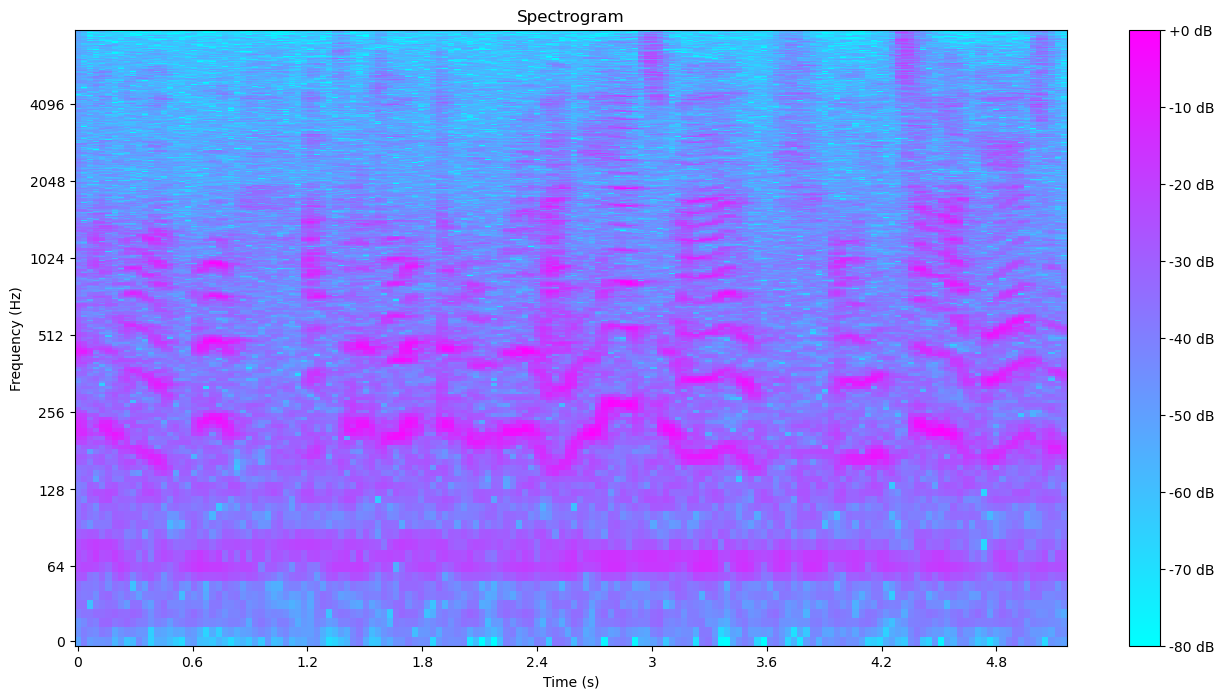

In [168]:
def plot_spectrogram(file_path, sr=16000):
    try:
        y, sr = librosa.load(file_path, sr=sr)
        trimmed_y, _ = librosa.effects.trim(y, top_db=20)
        D = librosa.amplitude_to_db(np.abs(librosa.stft(trimmed_y)), ref=np.max)
        
        # plot spectrogram
        plt.figure(figsize=(16, 8))
        librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log', cmap='cool')
        plt.colorbar(format='%+2.0f dB')
        plt.title('Spectrogram')
        plt.xlabel('Time (s)')
        plt.ylabel('Frequency (Hz)')
        plt.show()
    except Exception as e:
        print(f"Error processing {file_path}: {e}")

plot_spectrogram(audio_df['file_path'].iloc[0])

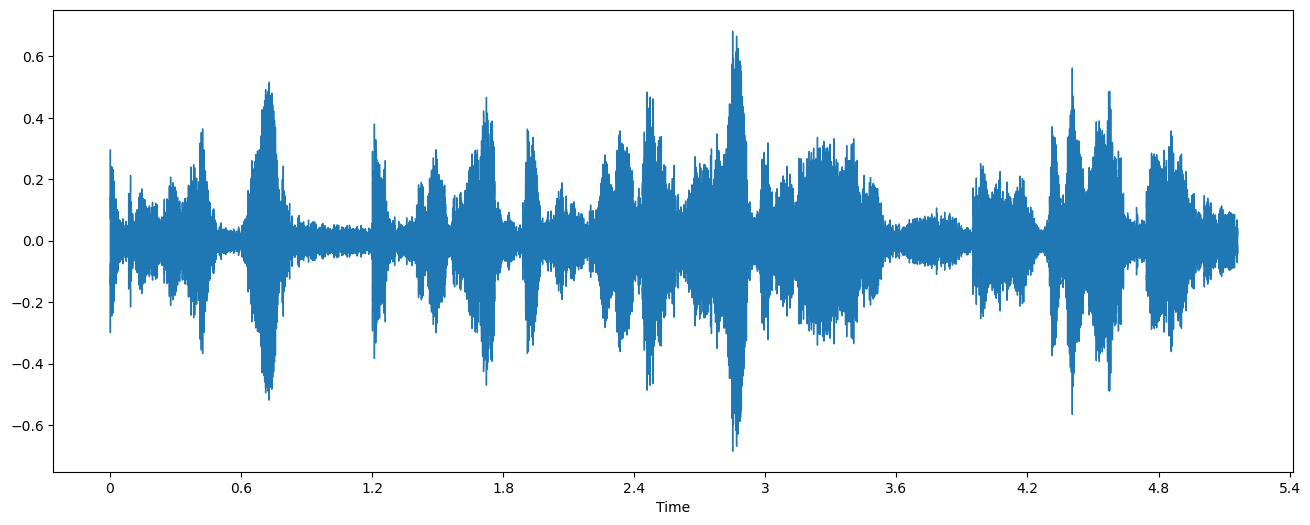

In [164]:
# visualize sample
y_origin, sr = librosa.load(audio_df['file_path'].iloc[0], sr=16000)
y_trimmed, _  = librosa.effects.trim(y_origin, top_db = 20)
plt.figure(figsize = (16, 6))
librosa.display.waveshow(y = y_trimmed, sr = 16000)

In [54]:
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)

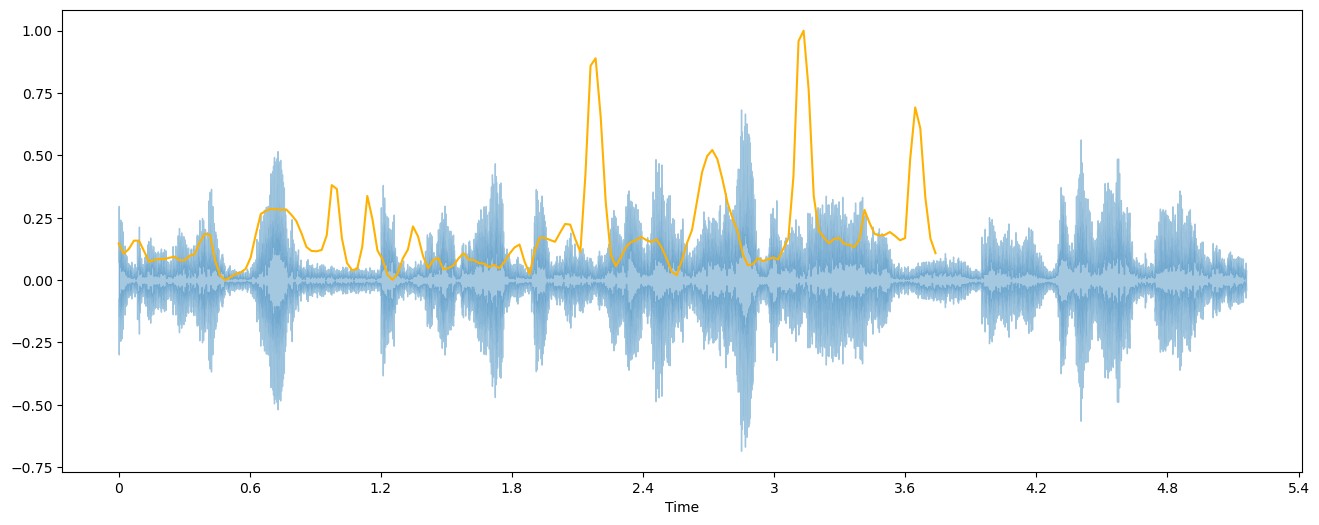

In [73]:
#visualize Spectral Centroid
spectral_centroid = librosa.feature.spectral_centroid(y = y_trimmed, sr=16000)[0]
frames = range(len(spectral_centroid))
t = librosa.frames_to_time(frames)
plt.figure(figsize = (16, 6))
librosa.display.waveshow(y_trimmed, sr=16000, alpha=0.4);
plt.plot(t, normalize(spectral_centroid), color='#FFB100');

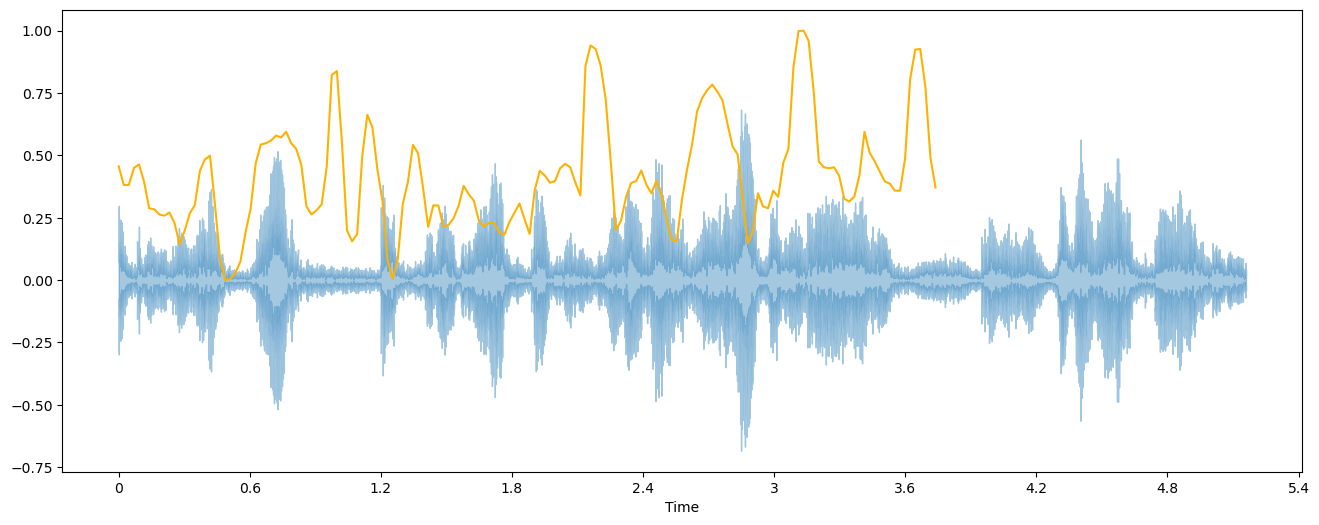

In [71]:
#visualize Spectral Rolloff
spectral_rolloff = librosa.feature.spectral_rolloff(y = y_trimmed, sr=16000)[0]
plt.figure(figsize = (16, 6))
librosa.display.waveshow(y_trimmed, sr=16000, alpha=0.4);
plt.plot(t, normalize(spectral_rolloff), color='#FFB100');

## Train Test Data Generation

In [389]:
# pick data with the first 200 persons (id10001 - id10201)
selected_ids = [f"id{str(i).zfill(5)}" for i in range(10001, 10201)]
sampled_audio_df = audio_df[audio_df['speaker_id'].isin(selected_ids)]
sampled_audio_df.reset_index(drop = True, inplace = True)
print(np.unique(sampled_audio_df))
print(np.shape(sampled_audio_df))
print(sampled_audio_df[:10])

['/Users/zhouzuojun/Desktop/675data/voxceleb1/wav1/id10001/1zcIwhmdeo4/00001.wav'
 '/Users/zhouzuojun/Desktop/675data/voxceleb1/wav1/id10001/1zcIwhmdeo4/00002.wav'
 '/Users/zhouzuojun/Desktop/675data/voxceleb1/wav1/id10001/1zcIwhmdeo4/00003.wav'
 ... 'zxgvcnhxT7M' 'zy3R9yhgrVY' 'zzee_m1OP_s']
(23809, 3)
  speaker_id     video_id                                          file_path
0    id10142  X8DC4kn1uPE  /Users/zhouzuojun/Desktop/675data/voxceleb1/wa...
1    id10142  X8DC4kn1uPE  /Users/zhouzuojun/Desktop/675data/voxceleb1/wa...
2    id10142  X8DC4kn1uPE  /Users/zhouzuojun/Desktop/675data/voxceleb1/wa...
3    id10142  X8DC4kn1uPE  /Users/zhouzuojun/Desktop/675data/voxceleb1/wa...
4    id10142  Sc6PCWA1kI0  /Users/zhouzuojun/Desktop/675data/voxceleb1/wa...
5    id10142  Sc6PCWA1kI0  /Users/zhouzuojun/Desktop/675data/voxceleb1/wa...
6    id10142  Sc6PCWA1kI0  /Users/zhouzuojun/Desktop/675data/voxceleb1/wa...
7    id10142  Sc6PCWA1kI0  /Users/zhouzuojun/Desktop/675data/voxceleb1/wa...
8 

In [391]:
# generate feature labels index matrix
max_samples = 200000000

features = Parallel(n_jobs=-1)(
    delayed(extract_features)(row['file_path']) 
    for idx, (index, row) in enumerate(tqdm(sampled_audio_df.iterrows(), total=min(len(sampled_audio_df), max_samples))) 
    if idx < max_samples
)

valid_rows = [
    (f, row['speaker_id'], index) 
    for idx, (f, (index, row)) in enumerate(zip(features, sampled_audio_df.iterrows())) 
    if f is not None and idx < max_samples
]
features, labels, indices = zip(*valid_rows)

X = np.array(features)
y = np.array(labels)

print("Feature Shape:", X.shape)
print("Labels Shape:", y.shape)


 29%|██▉       | 7020/23809 [13:23<27:17, 10.25it/s]/Users/zhouzuojun/anaconda3/lib/python3.11/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(

100%|██████████| 23809/23809 [42:16<00:00,  9.39it/s]


Feature Shape: (23660, 52)
Labels Shape: (23660,)


In [410]:
# Train test data split (80% train data, 20% test data)
aligned_audio_df = sampled_audio_df.iloc[list(indices)].reset_index(drop=True)

train_indices = []
val_indices = []

for speaker_id, group in aligned_audio_df.groupby("speaker_id"):
    video_ids = group["video_id"].unique()
    train_videos, test_videos = train_test_split(video_ids, test_size=0.2, random_state=42)
    
    train_indices.extend(group[group["video_id"].isin(train_videos)].index.tolist())
    val_indices.extend(group[group["video_id"].isin(test_videos)].index.tolist())

X_train, X_test = X[train_indices], X[val_indices]
y_train, y_test = y[train_indices], y[val_indices]

encoder = LabelEncoder()
y = encoder.fit_transform(y)  
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

print(X_train.shape)
print(X_test.shape)
print(np.unique(y_train))
print(np.unique(y_test))

(18475, 52)
(5185, 52)
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  


Feature Importances:
4     0.058046
36    0.046491
14    0.043770
6     0.042288
10    0.036740
12    0.035389
17    0.035022
22    0.030573
5     0.030314
1     0.030172
2     0.029935
15    0.027702
3     0.027078
0     0.026894
23    0.025192
7     0.025175
11    0.024684
9     0.023532
8     0.023157
16    0.022701
38    0.021657
21    0.020356
30    0.019947
29    0.019277
18    0.019086
20    0.018551
27    0.017517
13    0.016612
31    0.015685
19    0.014909
28    0.014844
33    0.014051
34    0.013168
24    0.013113
25    0.012579
26    0.011629
32    0.011402
35    0.010344
37    0.010013
41    0.005138
43    0.004973
48    0.004970
39    0.004939
49    0.004803
51    0.004799
47    0.004728
42    0.004593
50    0.004458
40    0.004454
44    0.004384
45    0.004121
46    0.004047
dtype: float32


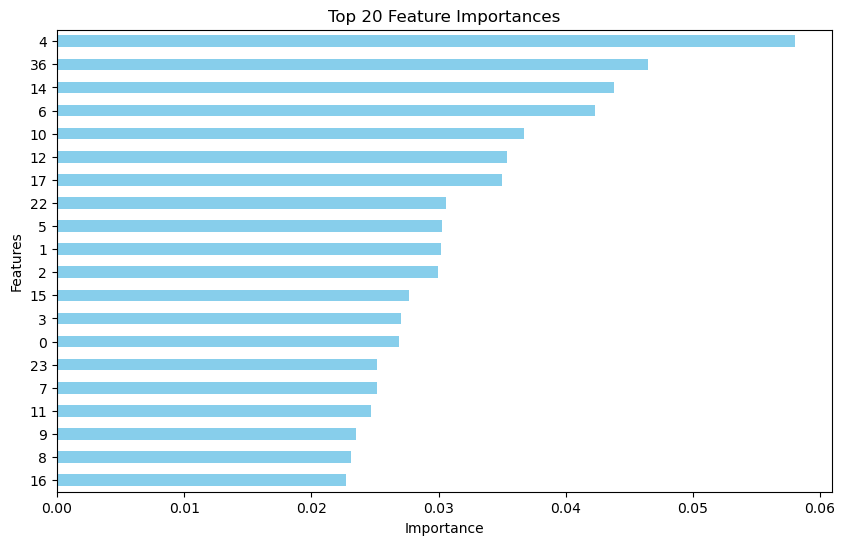


=== Trying threshold: 0.01 ===
Number of features selected: 39
Selected features: [4, 36, 14, 6, 10, 12, 17, 22, 5, 1, 2, 15, 3, 0, 23, 7, 11, 9, 8, 16, 38, 21, 30, 29, 18, 20, 27, 13, 31, 19, 28, 33, 34, 24, 25, 26, 32, 35, 37]
Cross-validated accuracy: 0.4757 ± 0.0640

=== Trying threshold: 0.015 ===
Number of features selected: 29
Selected features: [4, 36, 14, 6, 10, 12, 17, 22, 5, 1, 2, 15, 3, 0, 23, 7, 11, 9, 8, 16, 38, 21, 30, 29, 18, 20, 27, 13, 31]
Cross-validated accuracy: 0.4741 ± 0.0662

Selected Features for Test Set: (5185, 29)
Selected Features Names: [4, 36, 14, 6, 10, 12, 17, 22, 5, 1, 2, 15, 3, 0, 23, 7, 11, 9, 8, 16, 38, 21, 30, 29, 18, 20, 27, 13, 31]


In [446]:
# feature selection with XGboost
def feature_selection_pipeline(X, y, thresholds, cv=5):
    model = XGBClassifier(eval_metric='logloss', random_state=42)
    model.fit(X, y)

    feature_importances = pd.Series(
        model.feature_importances_,
        index=X.columns if hasattr(X, 'columns') else range(X.shape[1])
    )
    feature_importances = feature_importances.sort_values(ascending=False)
    # print all feature importance
    print("\nFeature Importances:")
    print(feature_importances)

    # visualize feature importance (threshold 0.01 and 0.015 comes from it)
    plt.figure(figsize=(10, 6))
    feature_importances.head(20).plot(kind='barh', color='skyblue')
    plt.title("Top 20 Feature Importances")
    plt.xlabel("Importance")
    plt.ylabel("Features")
    plt.gca().invert_yaxis()
    plt.show()

    results = {}

    for threshold in thresholds:
        print(f"\n=== Trying threshold: {threshold} ===")
        selector = SelectFromModel(model, threshold=threshold, prefit=True)
        X_selected = selector.transform(X)
        selected_features = feature_importances[feature_importances >= threshold].index.tolist()
        cv_scores = cross_val_score(model, X_selected, y, cv=cv, scoring='accuracy')

        print(f"Number of features selected: {len(selected_features)}")
        print(f"Selected features: {selected_features}")
        print(f"Cross-validated accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

        results[threshold] = {
            'selected_features': selected_features,
            'num_features': len(selected_features),
            'cv_score_mean': cv_scores.mean(),
            'cv_score_std': cv_scores.std()
        }

    return results, feature_importances

thresholds = [0.01, 0.015]
results, feature_importances = feature_selection_pipeline(
    pd.DataFrame(X_train), 
    y_train, 
    thresholds=thresholds
)

selected_features = results[thresholds[-1]]['selected_features']
X_test_selected = pd.DataFrame(X_test).iloc[:, selected_features]

print(f"\nSelected Features for Test Set: {X_test_selected.shape}")
print(f"Selected Features Names: {selected_features}")

In [450]:
# adjust train and test data with the chosen features
X_test_selected = pd.DataFrame(X_test).iloc[:, selected_features]
X_train_selected = pd.DataFrame(X_train).iloc[:, selected_features]

## Mahine learning Model

In [454]:
# Naive Bayes
NB_scaler = StandardScaler()
NB_X_train_scaled = NB_scaler.fit_transform(X_train_selected)
NB_X_test_scaled = NB_scaler.transform(X_test_selected)
NB = GaussianNB()
NB.fit(X_train_selected, y_train)
NB_y_pred = NB.predict(X_test_selected)
print(f"Test Accuracy: {accuracy_score(y_test, NB_y_pred):.4f}")

Test Accuracy: 0.2415


In [456]:
# Logistic Regression
LG_scaler = StandardScaler()
LG_X_train_scaled = LG_scaler.fit_transform(X_train_selected)
LG_X_test_scaled = LG_scaler.transform(X_test_selected)
LG = LogisticRegression(max_iter = 500, random_state=42)
LG.fit(LG_X_train_scaled, y_train)
LG_y_pred = LG.predict(LG_X_test_scaled)
print(f"Test Accuracy: {accuracy_score(y_test, LG_y_pred):.4f}")

Test Accuracy: 0.3641


In [457]:
# Support Vector Machine
SVM_scaler = StandardScaler()
SVM_X_train_scaled = SVM_scaler.fit_transform(X_train_selected)
SVM_X_test_scaled = SVM_scaler.transform(X_test_selected)
SVM = SVC(kernel='rbf', random_state=42)
SVM.fit(SVM_X_train_scaled, y_train)
SVM_y_pred = SVM.predict(SVM_X_test_scaled)
print(f"Test Accuracy: {accuracy_score(y_test, SVM_y_pred):.4f}")

Test Accuracy: 0.3761


In [459]:
# Random Forest
RF_scaler = StandardScaler()
RF_X_train_scaled = RF_scaler.fit_transform(X_train_selected)
RF_X_test_scaled = RF_scaler.transform(X_test_selected)

RF = RandomForestClassifier(n_estimators = 1000, max_depth=50, random_state=42)
RF.fit(RF_X_train_scaled, y_train)

RF_y_pred = RF.predict(RF_X_test_scaled)

print(f"Test Accuracy: {accuracy_score(y_test, RF_y_pred):.4f}")

Test Accuracy: 0.3383


In [85]:
# XGboost grid search 
def tune_xgboost(X, y, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1):
    xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
    grid_search = GridSearchCV(
        estimator=xgb,
        param_grid=param_grid,
        scoring=scoring,
        cv=cv,
        n_jobs=n_jobs,
        verbose=verbose
    )
    grid_search.fit(X, y)

    print("Best Parameters:", grid_search.best_params_)
    print("Best Score:", grid_search.best_score_)

    return grid_search

In [129]:
# XGboost
param_grid = {
    'learning_rate': [0.05],
    'max_depth': [5, 7, 10],
    'n_estimators': [500, 700, 1000],
    'subsample': [0.4, 0.6],
    'colsample_bytree': [0.4, 0.6],
    'gamma': [0.1, 0.3],
    'reg_alpha': [0.1, 0.5],
    'reg_lambda': [2, 5]
}

grid_search_result = tune_xgboost(
    X_train, y_train,
    param_grid=param_grid,
    cv=3,  
    scoring='accuracy', 
    n_jobs=-1,  
    verbose=2 
)

best_params = grid_search_result.best_params_
print("最佳参数:", best_params)

#best_xgb_model = grid_search_result.best_estimator_
#best_xgb_model.fit(X, y_encoded)

# y_pred = best_xgb_model.predict(X_test)

Fitting 3 folds for each of 288 candidates, totalling 864 fits


/Users/zhouzuojun/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [04:33:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/zhouzuojun/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [04:33:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/zhouzuojun/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [04:33:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/zhouzuojun/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [04:33:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

[CV] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=500, reg_alpha=0.1, reg_lambda=2, subsample=0.6; total time= 3.5min
[CV] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=500, reg_alpha=0.1, reg_lambda=5, subsample=0.6; total time= 3.2min


/Users/zhouzuojun/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/zhouzuojun/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [04:40:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=500, reg_alpha=0.1, reg_lambda=2, subsample=0.6; total time= 3.5min
[CV] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=500, reg_alpha=0.1, reg_lambda=5, subsample=0.6; total time= 3.2min


/Users/zhouzuojun/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [04:40:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=500, reg_alpha=0.1, reg_lambda=2, subsample=0.4; total time= 3.5min
[CV] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.4; total time= 3.8min


/Users/zhouzuojun/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [04:41:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/zhouzuojun/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [04:41:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/zhouzuojun/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [04:41:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/zhouzuojun/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [04:41:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

[CV] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=500, reg_alpha=0.1, reg_lambda=5, subsample=0.4; total time= 3.7min
[CV] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=500, reg_alpha=0.5, reg_lambda=5, subsample=0.4; total time= 4.3min


/Users/zhouzuojun/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [04:41:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/zhouzuojun/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [04:43:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=500, reg_alpha=0.1, reg_lambda=2, subsample=0.4; total time= 3.5min
[CV] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.4; total time= 3.0min
[CV] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=500, reg_alpha=0.5, reg_lambda=5, subsample=0.4; total time= 3.4min


/Users/zhouzuojun/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [04:43:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/zhouzuojun/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [04:44:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/zhouzuojun/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [04:44:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/zhouzuojun/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [04:45:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

[CV] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=500, reg_alpha=0.1, reg_lambda=2, subsample=0.4; total time= 3.5min
[CV] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.6; total time= 4.0min
[CV] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=700, reg_alpha=0.1, reg_lambda=2, subsample=0.4; total time= 4.1min


/Users/zhouzuojun/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [04:45:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/zhouzuojun/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [04:46:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/zhouzuojun/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [04:46:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/zhouzuojun/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [04:46:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

[CV] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=500, reg_alpha=0.1, reg_lambda=2, subsample=0.6; total time= 3.5min
[CV] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.4; total time= 4.1min
[CV] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=700, reg_alpha=0.1, reg_lambda=2, subsample=0.4; total time= 5.5min


/Users/zhouzuojun/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [04:47:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/zhouzuojun/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [04:47:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/zhouzuojun/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [04:48:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/zhouzuojun/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [04:49:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

[CV] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=700, reg_alpha=0.1, reg_lambda=5, subsample=0.6; total time= 4.2min
[CV] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=700, reg_alpha=0.5, reg_lambda=5, subsample=0.4; total time= 5.2min


/Users/zhouzuojun/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [04:55:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/zhouzuojun/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [04:56:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=500, reg_alpha=0.1, reg_lambda=5, subsample=0.4; total time= 3.6min
[CV] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.6; total time= 3.0min
[CV] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=500, reg_alpha=0.5, reg_lambda=5, subsample=0.6; total time= 3.2min
[CV] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=700, reg_alpha=0.1, reg_lambda=5, subsample=0.4; total time= 4.3min
[CV] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=700, reg_alpha=0.5, reg_lambda=2, subsample=0.6; total time= 4.2min
[CV] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=1000, reg_alpha=0.1, reg_lambda=2, subsample=0.4; total time= 5.5min


/Users/zhouzuojun/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [04:57:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/zhouzuojun/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [04:57:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/zhouzuojun/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [04:58:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/zhouzuojun/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [04:58:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

[CV] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=500, reg_alpha=0.5, reg_lambda=5, subsample=0.6; total time= 3.4min
[CV] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=700, reg_alpha=0.1, reg_lambda=5, subsample=0.4; total time= 6.0min
[CV] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=700, reg_alpha=0.5, reg_lambda=5, subsample=0.6; total time= 4.7min
[CV] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=1000, reg_alpha=0.1, reg_lambda=5, subsample=0.4; total time= 5.3min
[CV] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.6; total time= 4.7min


/Users/zhouzuojun/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [05:04:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/zhouzuojun/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [05:04:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/zhouzuojun/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [05:04:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/zhouzuojun/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [05:06:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

[CV] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=1000, reg_alpha=0.1, reg_lambda=5, subsample=0.4; total time= 5.5min
[CV] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=5, subsample=0.4; total time= 6.3min
[CV] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=7, n_estimators=500, reg_alpha=0.1, reg_lambda=2, subsample=0.6; total time= 4.1min
[CV] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.4; total time= 3.1min


/Users/zhouzuojun/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [05:14:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=700, reg_alpha=0.1, reg_lambda=2, subsample=0.4; total time= 4.1min
[CV] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=700, reg_alpha=0.1, reg_lambda=5, subsample=0.6; total time= 4.2min
[CV] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=700, reg_alpha=0.5, reg_lambda=5, subsample=0.4; total time= 4.1min
[CV] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=1000, reg_alpha=0.1, reg_lambda=2, subsample=0.6; total time= 6.8min
[CV] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.6; total time= 6.5min
[CV] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=7, n_estimators=500, reg_alpha=0.1, reg_lambda=2, subsample=0.6; total time= 3.5min
[CV] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, 

/Users/zhouzuojun/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [05:14:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/zhouzuojun/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [05:14:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/zhouzuojun/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [05:15:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=700, reg_alpha=0.1, reg_lambda=2, subsample=0.6; total time= 4.7min
[CV] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=700, reg_alpha=0.5, reg_lambda=2, subsample=0.4; total time= 5.5min
[CV] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=1000, reg_alpha=0.1, reg_lambda=2, subsample=0.4; total time= 5.6min
[CV] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=1000, reg_alpha=0.1, reg_lambda=5, subsample=0.6; total time= 7.1min
[CV] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=7, n_estimators=500, reg_alpha=0.1, reg_lambda=2, subsample=0.4; total time= 3.8min
[CV] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=7, n_estimators=500, reg_alpha=0.1, reg_lambda=5, subsample=0.4; total time= 3.3min
[CV] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, 

/Users/zhouzuojun/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [05:15:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/zhouzuojun/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [05:17:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/zhouzuojun/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [05:17:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/zhouzuojun/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [05:17:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

[CV] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=5, subsample=0.6; total time= 5.9min
[CV] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=7, n_estimators=500, reg_alpha=0.1, reg_lambda=5, subsample=0.6; total time= 3.3min
[CV] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=7, n_estimators=500, reg_alpha=0.5, reg_lambda=5, subsample=0.6; total time= 3.4min


/Users/zhouzuojun/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [05:17:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/zhouzuojun/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [05:17:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/zhouzuojun/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [05:18:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/zhouzuojun/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [05:19:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

[CV] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=7, n_estimators=700, reg_alpha=0.1, reg_lambda=5, subsample=0.4; total time= 5.2min
[CV] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=7, n_estimators=700, reg_alpha=0.5, reg_lambda=2, subsample=0.6; total time= 3.8min
[CV] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=7, n_estimators=1000, reg_alpha=0.1, reg_lambda=2, subsample=0.4; total time= 5.1min
[CV] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=7, n_estimators=1000, reg_alpha=0.1, reg_lambda=5, subsample=0.6; total time= 5.6min
[CV] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=5, subsample=0.4; total time= 5.3min
[CV] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=10, n_estimators=500, reg_alpha=0.1, reg_lambda=2, subsample=0.6; total time= 3.8min
[CV] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05

/Users/zhouzuojun/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [06:25:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/zhouzuojun/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [06:26:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/zhouzuojun/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [06:26:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/zhouzuojun/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [06:26:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

[CV] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=500, reg_alpha=0.1, reg_lambda=5, subsample=0.6; total time= 3.7min
[CV] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=500, reg_alpha=0.5, reg_lambda=5, subsample=0.4; total time= 4.1min
[CV] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=700, reg_alpha=0.1, reg_lambda=2, subsample=0.6; total time= 4.7min
[CV] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=700, reg_alpha=0.5, reg_lambda=2, subsample=0.4; total time= 3.8min
[CV] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=700, reg_alpha=0.5, reg_lambda=5, subsample=0.6; total time= 4.6min
[CV] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=1000, reg_alpha=0.1, reg_lambda=5, subsample=0.4; total time= 5.4min
[CV] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, m

/Users/zhouzuojun/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [06:31:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=500, reg_alpha=0.1, reg_lambda=5, subsample=0.4; total time= 3.7min
[CV] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.6; total time= 4.0min
[CV] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=700, reg_alpha=0.1, reg_lambda=2, subsample=0.6; total time= 4.8min
[CV] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=700, reg_alpha=0.5, reg_lambda=2, subsample=0.4; total time= 4.9min
[CV] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=700, reg_alpha=0.5, reg_lambda=5, subsample=0.6; total time= 4.8min
[CV] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=1000, reg_alpha=0.1, reg_lambda=5, subsample=0.6; total time= 6.2min
[CV] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, m

/Users/zhouzuojun/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [06:31:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/zhouzuojun/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [06:32:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/zhouzuojun/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [06:32:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/zhouzuojun/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [06:32:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

[CV] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=1000, reg_alpha=0.1, reg_lambda=5, subsample=0.6; total time= 5.7min
[CV] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=5, subsample=0.4; total time= 5.5min
[CV] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=7, n_estimators=500, reg_alpha=0.1, reg_lambda=5, subsample=0.4; total time= 4.6min
[CV] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=7, n_estimators=500, reg_alpha=0.5, reg_lambda=5, subsample=0.4; total time= 3.5min
[CV] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=7, n_estimators=700, reg_alpha=0.1, reg_lambda=2, subsample=0.6; total time= 4.0min
[CV] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=7, n_estimators=700, reg_alpha=0.5, reg_lambda=2, subsample=0.4; total time= 5.3min
[CV] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, 

/Users/zhouzuojun/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [06:34:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/zhouzuojun/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [06:36:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/zhouzuojun/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [06:36:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/zhouzuojun/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [06:36:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

[CV] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=700, reg_alpha=0.5, reg_lambda=2, subsample=0.6; total time= 4.4min
[CV] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=1000, reg_alpha=0.1, reg_lambda=2, subsample=0.4; total time= 7.1min
[CV] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.4; total time= 5.3min
[CV] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=5, subsample=0.6; total time= 5.2min
[CV] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=7, n_estimators=500, reg_alpha=0.1, reg_lambda=5, subsample=0.4; total time= 3.8min
[CV] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.6; total time= 4.4min
[CV] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05,

/Users/zhouzuojun/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [06:37:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.4, gamma=0.3, learning_rate=0.05, max_depth=5, n_estimators=700, reg_alpha=0.1, reg_lambda=5, subsample=0.4; total time= 3.6min
[CV] END colsample_bytree=0.4, gamma=0.3, learning_rate=0.05, max_depth=5, n_estimators=700, reg_alpha=0.5, reg_lambda=2, subsample=0.6; total time= 3.7min
[CV] END colsample_bytree=0.4, gamma=0.3, learning_rate=0.05, max_depth=5, n_estimators=1000, reg_alpha=0.1, reg_lambda=2, subsample=0.4; total time= 4.8min


/Users/zhouzuojun/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [06:37:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/zhouzuojun/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [06:38:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/zhouzuojun/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [06:38:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/zhouzuojun/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [06:38:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

[CV] END colsample_bytree=0.4, gamma=0.3, learning_rate=0.05, max_depth=5, n_estimators=700, reg_alpha=0.5, reg_lambda=5, subsample=0.4; total time= 5.0min
[CV] END colsample_bytree=0.4, gamma=0.3, learning_rate=0.05, max_depth=5, n_estimators=1000, reg_alpha=0.1, reg_lambda=5, subsample=0.4; total time= 6.4min


/Users/zhouzuojun/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [06:42:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/zhouzuojun/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [06:43:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/zhouzuojun/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [06:43:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/zhouzuojun/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [06:43:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

[CV] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=7, n_estimators=700, reg_alpha=0.1, reg_lambda=2, subsample=0.4; total time= 4.2min
[CV] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=7, n_estimators=700, reg_alpha=0.5, reg_lambda=2, subsample=0.4; total time= 5.2min
[CV] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=7, n_estimators=700, reg_alpha=0.5, reg_lambda=5, subsample=0.6; total time= 4.5min
[CV] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=7, n_estimators=1000, reg_alpha=0.1, reg_lambda=5, subsample=0.4; total time= 7.5min
[CV] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=5, subsample=0.4; total time= 7.3min
[CV] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=10, n_estimators=500, reg_alpha=0.1, reg_lambda=5, subsample=0.6; total time= 3.8min
[CV] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05,

/Users/zhouzuojun/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [08:33:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/zhouzuojun/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [08:33:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/zhouzuojun/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [08:33:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=700, reg_alpha=0.1, reg_lambda=5, subsample=0.4; total time= 4.3min
[CV] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=700, reg_alpha=0.5, reg_lambda=2, subsample=0.6; total time= 4.1min
[CV] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=1000, reg_alpha=0.1, reg_lambda=2, subsample=0.6; total time= 5.7min
[CV] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.4; total time= 6.7min
[CV] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=5, subsample=0.6; total time= 6.1min
[CV] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.4; total time= 4.0min
[CV] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05,

/Users/zhouzuojun/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [08:34:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/zhouzuojun/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [08:35:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/zhouzuojun/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [08:35:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/zhouzuojun/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [08:36:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.05, max_depth=7, n_estimators=700, reg_alpha=0.1, reg_lambda=5, subsample=0.4; total time= 6.1min
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.05, max_depth=7, n_estimators=700, reg_alpha=0.5, reg_lambda=5, subsample=0.4; total time= 4.5min


/Users/zhouzuojun/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [08:44:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/zhouzuojun/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [08:45:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/zhouzuojun/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [08:45:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/zhouzuojun/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [08:45:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.05, max_depth=7, n_estimators=700, reg_alpha=0.1, reg_lambda=2, subsample=0.6; total time= 3.9min
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.05, max_depth=7, n_estimators=700, reg_alpha=0.5, reg_lambda=2, subsample=0.4; total time= 4.2min
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.05, max_depth=7, n_estimators=700, reg_alpha=0.5, reg_lambda=5, subsample=0.6; total time= 4.9min
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.05, max_depth=7, n_estimators=1000, reg_alpha=0.1, reg_lambda=5, subsample=0.4; total time= 7.2min
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.05, max_depth=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=5, subsample=0.4; total time= 5.5min
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.05, max_depth=10, n_estimators=500, reg_alpha=0.1, reg_lambda=2, subsample=0.6; total time= 3.4min
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.05,

/Users/zhouzuojun/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [09:10:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/zhouzuojun/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [09:10:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/zhouzuojun/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [09:11:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/zhouzuojun/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [09:11:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.05, max_depth=10, n_estimators=700, reg_alpha=0.1, reg_lambda=5, subsample=0.4; total time= 5.0min
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.05, max_depth=10, n_estimators=700, reg_alpha=0.5, reg_lambda=5, subsample=0.4; total time= 4.4min
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.05, max_depth=10, n_estimators=1000, reg_alpha=0.1, reg_lambda=2, subsample=0.6; total time= 5.2min


/Users/zhouzuojun/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [09:25:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/zhouzuojun/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [09:27:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/zhouzuojun/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [09:28:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/zhouzuojun/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [09:28:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

[CV] END colsample_bytree=0.4, gamma=0.3, learning_rate=0.05, max_depth=5, n_estimators=1000, reg_alpha=0.1, reg_lambda=2, subsample=0.6; total time= 5.0min
[CV] END colsample_bytree=0.4, gamma=0.3, learning_rate=0.05, max_depth=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.6; total time= 5.4min
[CV] END colsample_bytree=0.4, gamma=0.3, learning_rate=0.05, max_depth=7, n_estimators=500, reg_alpha=0.1, reg_lambda=2, subsample=0.4; total time= 3.5min
[CV] END colsample_bytree=0.4, gamma=0.3, learning_rate=0.05, max_depth=7, n_estimators=500, reg_alpha=0.1, reg_lambda=5, subsample=0.4; total time= 3.8min
[CV] END colsample_bytree=0.4, gamma=0.3, learning_rate=0.05, max_depth=7, n_estimators=500, reg_alpha=0.5, reg_lambda=5, subsample=0.4; total time= 3.9min
[CV] END colsample_bytree=0.4, gamma=0.3, learning_rate=0.05, max_depth=7, n_estimators=700, reg_alpha=0.1, reg_lambda=5, subsample=0.4; total time= 4.4min
[CV] END colsample_bytree=0.4, gamma=0.3, learning_rate=0.05, 

In [461]:
# XGboost
xgb_optimized = XGBClassifier(**grid_search_result.best_params_, random_state=42, eval_metric="mlogloss")
xgb_optimized.fit(X_train_selected, y_train)

preds = xgb_optimized.predict(X_test_selected)
accuracy = accuracy_score(y_test, preds)
print(f"Test Accuracy: {accuracy:.5f}")

Test Accuracy: 0.35352
